In [1]:
import numpy as np
from numpy.random import Generator, PCG64
import matplotlib.pyplot as plt
import math
import time
from heateq import Exact, Simulateur

In [2]:
seed = 213731490053398181466621250222036675538
rng = Generator(PCG64(seed))

In [3]:
# Permet d'obtenir un n-échantillon du vecteur aléatoire d'entrée X
def n_echantillon_X(n):
    return np.vstack(
        (
            rng.uniform(-math.pi, math.pi, (3, n)),
            rng.uniform(0.001, 0.009, (1, n)), 
            rng.uniform(-1., 1., (3, n))
        )
    )

In [4]:
# Simulateurs haute et basse fidélité
f = Simulateur(21, 100)
g = Simulateur(3, 20)

In [5]:
# Espérance exacte de la solution continue
mu_exact = Exact().mu
print(mu_exact)

# Espérance exacte de Y = f(X) (solution discrétisée, haute fidélité)
mu_Y_exact = f.mu
print(mu_Y_exact)

# Espérance exacte de Z = g(X) (solution discrétisée, basse fidélité)
mu_Z_exact = g.mu
print(mu_Z_exact)

41.98447216482205
41.916465294707976
33.03617206344313


# Espérance $\mu_Z$ connue

On considère $\mu_Z$ connue. Elle est donnée par la variable `mu_Z_exact`.

## Paramètre optimal $\alpha^*$ indépendant (précalculé)
Estimer $\alpha^*$ de manière indépendante (avec, par exemple, un échantilon de taille `p = 1000`), puis $\rho^2$, et en déduire $\beta=(1+w)(1-\rho^2)$. L'utiliser pour contruire un estimateur par variable de contrôle pour l'espérance de $Y$. Faire `nr = 1000` répétitions pour des budgets $\tilde{n} \in \{5; 10; 20; 50; 100; 200; 500; 1000\}$.

Estimer la réduction de variance à budget équivalent entre l'estimateur par variable de contrôle et l'estimateur Monte Carlo classique (haute fidélité). Est-elle conforme à la valeur de $\beta$ calculée précédemment ?

Tracer l'espérance et l'écart-type des estimateurs par variable de contrôle et Monte Carlo (haute fidélité) à budget équivalent en fonction de $\tilde{n}$. Sur un autre graphe, tracer l'évolution de l'écart-type des estimateurs en fonction de $\tilde{n}$.

In [19]:
p = 1000
X = n_echantillon_X(p)
tf_start = time.process_time() 
Y = f(X)
tf_stop = time.process_time()
cf = tf_start - tf_stop

tg_start = time.process_time() 
Z = g(X)
tg_stop = time.process_time()
cg = tg_start - tg_stop

alpha_opti = np.cov(Y, Z)[0,1]/np.var(Z)
print('alpha_opti : ', alpha_opti)
rho_square = np.cov(Y, Z)[0,1]**2/(np.var(Z)*np.var(Y))
print('rho_square :', rho_square)
omega = cg/cf
beta = (1+omega)*(1-rho_square)
print('beta : ', beta)

Y_estim = np.mean(Y) - alpha_opti*(np.mean(Z) - mu_Z_exact)
print(Y_estim)

alpha_opti :  1.0133775841094141
rho_square : 0.9887840961712387
beta :  0.011644952837586521
42.033919222866956


In [41]:
nr = 1000
budgets = [5, 10, 20, 50, 100, 200, 1000]
list_mean_f_bugdet = []
list_mean_y_estim_budget = []
list_var_f_budget = []
list_var_y_estim_budget = []
betas_var = []
betas_formula = []

for n_tilde in budgets:
    print(n_tilde)
    list_mean_f_nr = []
    list_mean_y_estim_nr = []
    list_var_f_nr = []
    list_var_y_estim_nr = []
    betas_formula_nr = []
    
    for i in range(nr):
        X = n_echantillon_X(n_tilde)
        tf_start = time.process_time() 
        Y = f(X)
        tf_stop = time.process_time()
        cf = tf_start - tf_stop
        
        tg_start = time.process_time() 
        Z = g(X)
        tg_stop = time.process_time()
        cg = tg_start - tg_stop

        omega = cg/cf

        alpha_opti = np.cov(Y, Z)[0,1]/np.var(Z)
        Y_estim = np.mean(Y) - alpha_opti*(np.mean(Z) - mu_Z_exact)
        rho_square = np.cov(Y, Z)[0,1]**2/(np.var(Z)*np.var(Y))
        list_mean_y_estim_nr.append(Y_estim)
        list_var_y_estim_nr.append(Y_estim)
        betas_formula_nr.append((1+omega)*(1-rho_square))


        n = math.floor(n_tilde/(1+omega))
        X_f = n_echantillon_X(n)
        Y_f = f(X_f)
        list_mean_f_nr.append(np.mean(Y_f))
        list_var_f_nr.append(np.mean(Y_f))

    betas_formula.append(np.mean(betas_formula_nr))
    list_mean_f_bugdet.append(np.mean(list_mean_f_nr))
    list_mean_y_estim_budget.append(np.mean(list_mean_y_estim_nr))
    list_var_f_budget.append(np.var(list_var_f_nr))
    list_var_y_estim_budget.append(np.var(list_var_y_estim_nr))
    betas_var.append(np.var(list_var_y_estim_nr)/np.var(list_var_f_nr))
        

5
10
20
50
100
200
1000


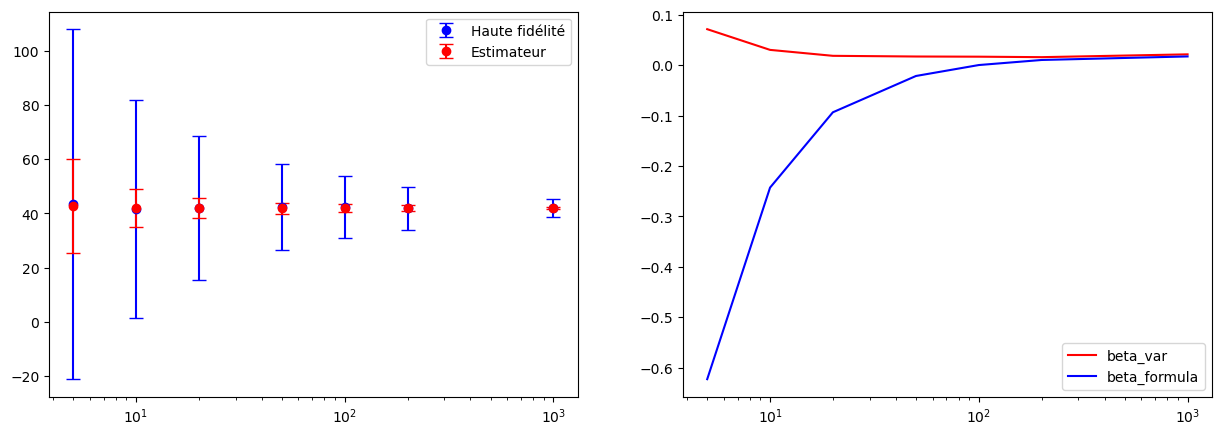

In [42]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].errorbar(budgets, list_mean_f_bugdet, yerr=np.sqrt(list_var_f_budget), fmt='o', color='b', capsize=5, label = 'Haute fidélité')
axs[0].errorbar(budgets, list_mean_y_estim_budget, yerr=np.sqrt(list_var_y_estim_budget), fmt='o', color='r', capsize=5, label = 'Estimateur')
axs[0].set_xscale('log')  # Appliquer l'échelle logarithmique
axs[1].plot(budgets, betas_var, label = 'beta_var', color = 'r')
axs[1].plot(budgets, betas_formula, label = 'beta_formula', color = 'b')
axs[1].set_xscale('log') 
# axs[1].set_yscale('log')  

for ax in axs:
    ax.legend()
plt.show()

## Paramètre optimal $\alpha^*$ estimé à la volée
Renouveler l'expérience avec $\alpha^*$ estimé avec les échantillons disponibles pour l'estimation par variable de contrôle.

Tracer les mêmes graphes que précédemment. L'estimation de $\alpha^*$ à la volée induit-elle un biais et/ou une dégradation de la réduction de variance ?

## Métamodèle

Mêmes questions en utilisant un métamodèle comme simulateur basse fidélité.
Voir, par exemple, https://openturns.github.io/openturns/latest/auto_meta_modeling/kriging_metamodel/plot_kriging.html

In [ ]:
import openturns as ot

In [ ]:
# pour faciliter l'évaluation de la même manière que nos simulateurs
class ScalarModel_from_ot:
    def __init__(self, ot_model):
        self.ot_model = ot_model

    def __call__(self, xi):
        return np.array(self.ot_model(xi.T))[:,0]

In [ ]:
n_doe = 1000
X_doe = n_echantillon_X(n_doe)
Y_doe = f(X_doe)
dimension = X_doe.shape[0]

In [ ]:
basis = ot.ConstantBasisFactory(dimension).build()
covarianceModel = ot.MaternModel([1.0] * dimension, 1.5)
algo = ot.KrigingAlgorithm(X_doe.T, Y_doe[:,None], covarianceModel, basis) # conversion to OpenTurns data structure
algo.run()
res = algo.getResult()
g_mm = ScalarModel_from_ot( res.getMetaModel() )

## Plusieurs variables de contrôle

Combiner plusieurs simulateurs basse fidélité (supposer $\mu_Z$ connue), et estimer $R^2$.